In [0]:
import fix_yahoo_finance as fyf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

In [2]:
fyf.pdr_override()
goog = pdr.get_data_yahoo('GOOG', start = '2015-05-27', end = '2020-05-30')
goog.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-27,532.799988,540.549988,531.710022,539.789978,539.789978,1525000
2015-05-28,538.010010,540.609985,536.250000,539.780029,539.780029,1029800
2015-05-29,537.369995,538.630005,531.450012,532.109985,532.109985,2597400
2015-06-01,536.789978,536.789978,529.760010,533.989990,533.989990,1904300
2015-06-02,532.929993,543.000000,531.330017,539.179993,539.179993,1939000


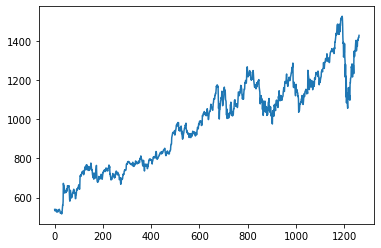

In [3]:
df = goog.reset_index()['Adj Close']

plt.plot(df)

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [0]:
training_size = int(len(df) * 0.65)
test_size = len(df) - training_size

train_data = df[0:training_size, :]
test_data = df[training_size:len(df), :1]

In [0]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)

In [0]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
print('X_train:-', X_train.shape, '\ny_train:-', y_train.shape, '\nX_test:-', X_test.shape, '\ny_test:-', y_test.shape)

X_train:- (719, 100) 
y_train:- (719,) 
X_test:- (341, 100) 
y_test:- (341,)


In [0]:
# reshaping input as per LSTM requirement - [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [11]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0554 - val_loss: 0.0210
Epoch 2/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0077 - val_loss: 0.0058
Epoch 3/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0043 - val_loss: 0.0157
Epoch 4/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 5/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 6/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 7/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 8/100
12/12 [==============================] - 1s 73ms/step - loss: 9.8550e-04 - val_loss: 0.0045
Epoch 9/100
12/12 [==============================] - 1s 74ms/step - loss: 9.3820e-04 - val_loss: 0.0047
Epoch 10/100
12/12 [==============================] - 1s 72ms/step - loss: 9.5344e-04 - val

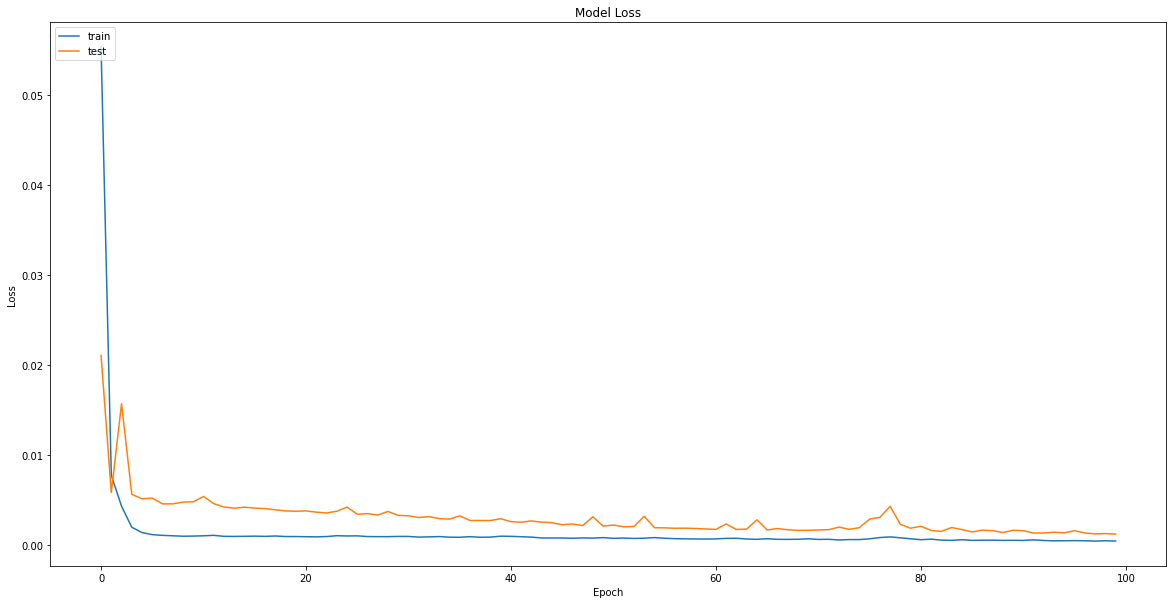

In [13]:
# summarize history for loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#For prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [0]:
#Inverse transforming back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [16]:
print('RMSE on train set:- ', math.sqrt(mean_squared_error(y_train, train_predict)))
print('RMSE on test set:- ', math.sqrt(mean_squared_error(y_test,test_predict)))

RMSE on train set:-  903.7041614138333
RMSE on test set:-  1240.271996989236


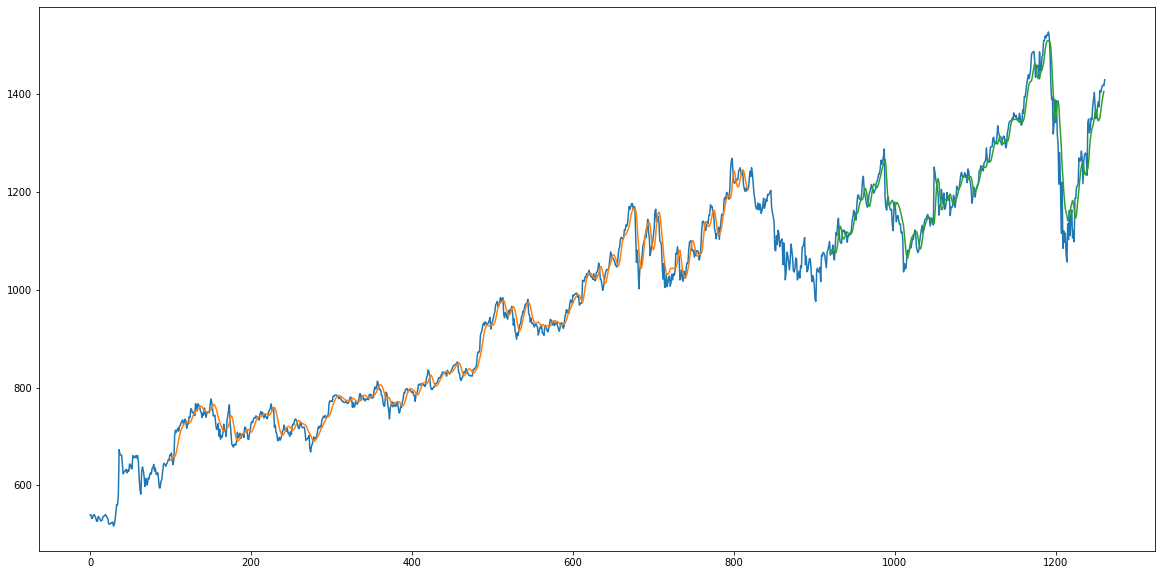

In [17]:
# Plotting 
plt.figure(figsize=(20, 10))
# shift train predictions for plotting
look_back=100
train_Predict_Plot = np.empty_like(df)
train_Predict_Plot[:, :] = np.nan
train_Predict_Plot[look_back : len(train_predict) + look_back, :] = train_predict
# shift test predictions for plotting
test_Predict_Plot = np.empty_like(df)
test_Predict_Plot[:, :] = np.nan
test_Predict_Plot[len(train_predict) + (look_back*2) + 1:len(df) - 1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(train_Predict_Plot)
plt.plot(test_Predict_Plot)
plt.show()

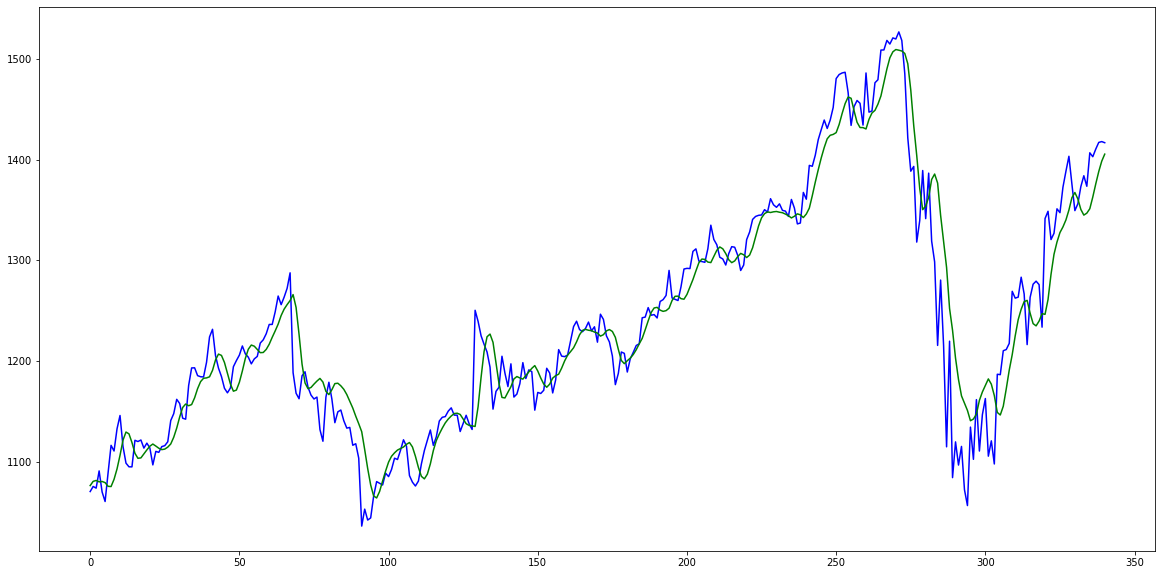

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), c = 'blue')
plt.plot(test_predict, c = 'green')

In [19]:
x_input = test_data[len(test_data) - 100:].reshape(1,-1)
x_input.shape

(1, 100)

In [0]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [0]:
# prediction for next days
from numpy import array

days = 10
lst_output = []
n_steps = 100
i = 0

while(i < days):  
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i+1

In [0]:
day_new = np.arange(1,101)
day_pred = np.arange(101,101+days)

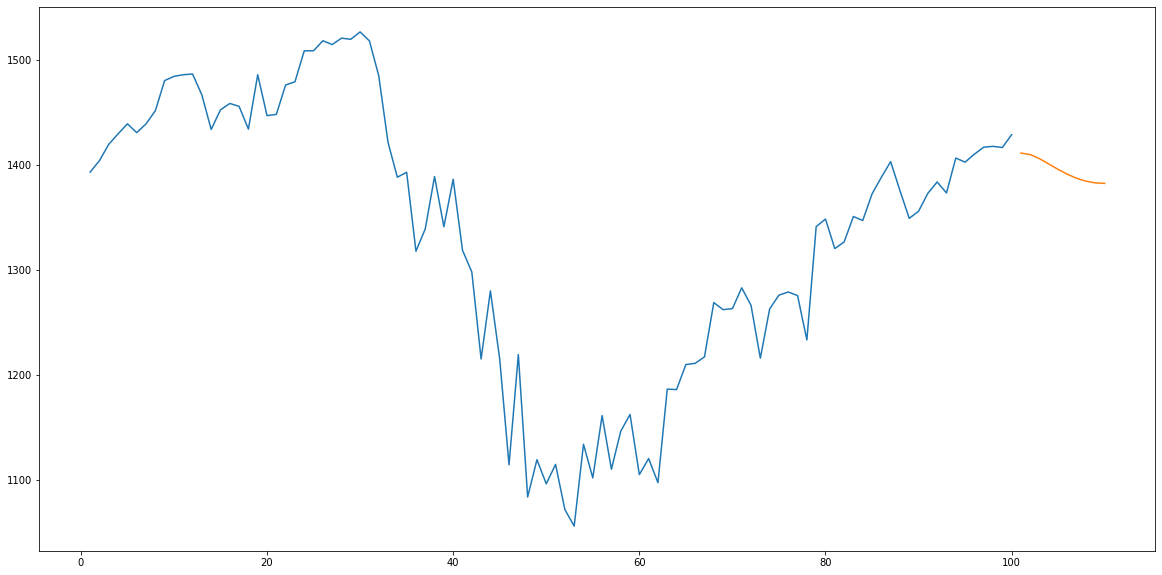

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(day_new, scaler.inverse_transform(df[len(df) - 100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

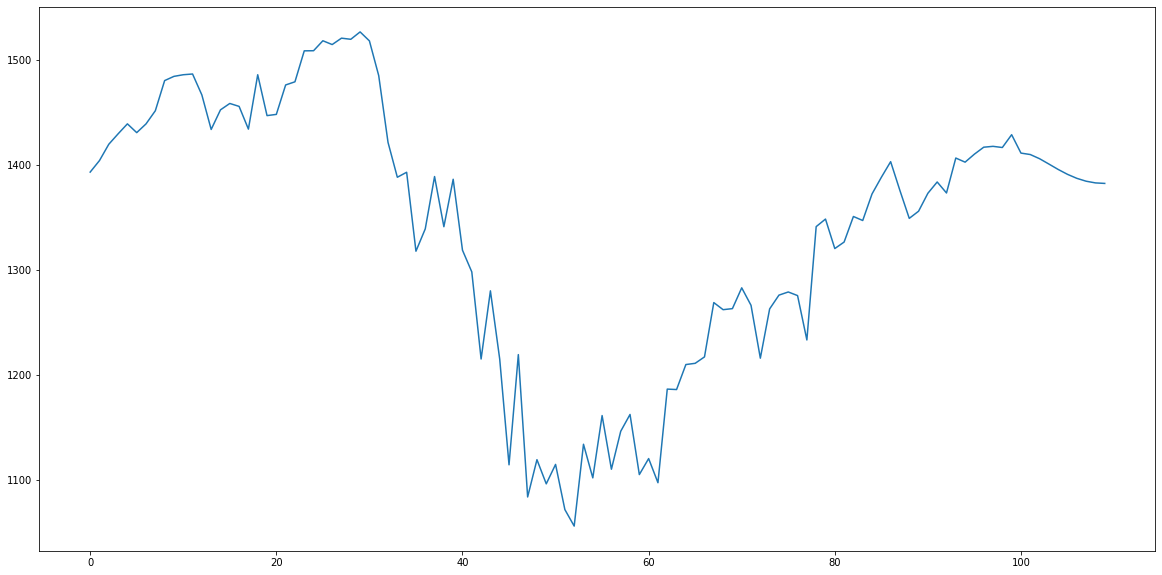

In [24]:
plt.figure(figsize=(20, 10))
df1 = df.tolist()
df1.extend(lst_output)
plt.plot(scaler.inverse_transform(df1[len(df1) - (100 + days):]))

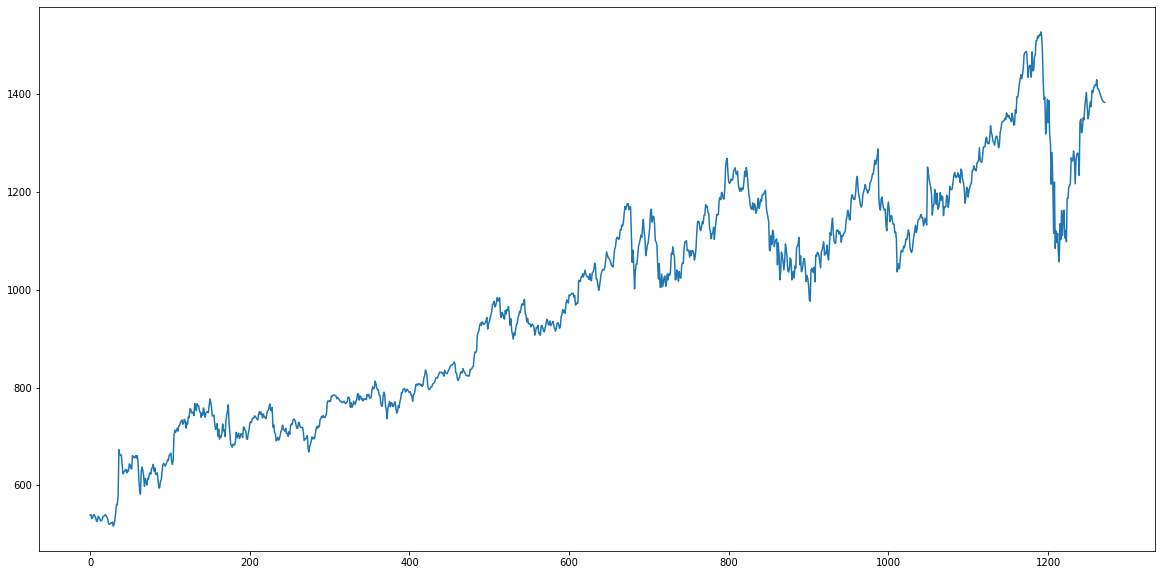

In [25]:
plt.figure(figsize=(20, 10))
df1 = scaler.inverse_transform(df1).tolist()
plt.plot(df1)